In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#data_utils.py
import pickle
import numpy as np
import os
from matplotlib.pyplot import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding = 'latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [0]:
#linear_svm.py
from random import shuffle
import sys

def svm_loss_naive(W, X, y, reg):
    """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        loss_contributors_count = 0
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                # incorrect class gradient part
                dW[:, j] += X[i]
                # count contributor terms to loss function
                loss_contributors_count += 1
        # correct class gradient part
        dW[:, y[i]] += (-1) * loss_contributors_count * X[i]

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train
    dW /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)
    # Add regularization to the gradient
    dW += 2 * reg * W
    return loss, dW


def svm_loss_vectorized(W, X, y, reg):
    """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero
    num_train = X.shape[0]
    # s: A numpy array of shape (N, C) containing scores
    s = X.dot(W)
    # read correct scores into a column array of height N
    correct_score = s[list(range(num_train)), y]
    correct_score = correct_score.reshape(num_train, -1)
    # subtract correct scores from score matrix and add margin
    s += 1 - correct_score
    # make sure correct scores themselves don't contribute to loss function
    s[list(range(num_train)), y] = 0
    # construct loss function
    loss = np.sum(np.fmax(s, 0)) / num_train
    loss += reg * np.sum(W * W)
    X_mask = np.zeros(s.shape)
    X_mask[s > 0] = 1
    X_mask[np.arange(num_train), y] = -np.sum(X_mask, axis=1)
    dW = X.T.dot(X_mask)
    dW /= num_train
    dW += 2 * reg * W
    return loss, dW


In [0]:
#softmax.py
def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_classes = W.shape[1]
  num_train = X.shape[0]

  for i in range(num_train):

      # loss
      scores = X[i].dot(W)
      # shift values for 'scores' for numeric reasons (over-flow cautious)
      scores -= scores.max()
      scores_expsum = np.sum(np.exp(scores))
      cor_ex = np.exp(scores[y[i]])
      loss += - np.log( cor_ex / scores_expsum)

      # grad
      # for correct class
      dW[:, y[i]] += (-1) * (scores_expsum - cor_ex) / scores_expsum * X[i]
      for j in range(num_classes):
          # pass correct class gradient
          if j == y[i]:
              continue
          # for incorrect classes
          dW[:, j] += np.exp(scores[j]) / scores_expsum * X[i]

  loss /= num_train
  loss += reg * np.sum(W * W)
  dW /= num_train
  dW += 2 * reg * W
  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_classes = W.shape[1]
  num_train = X.shape[0]
  # loss
  # score: N by C matrix containing class scores
  scores = X.dot(W)
  scores -= scores.max()
  scores = np.exp(scores)
  scores_sums = np.sum(scores, axis=1)
  cors = scores[range(num_train), y]
  loss = cors / scores_sums
  loss = -np.sum(np.log(loss))/num_train + reg * np.sum(W * W)

  # grad
  s = np.divide(scores, scores_sums.reshape(num_train, 1))
  s[range(num_train), y] = - (scores_sums - cors) / scores_sums
  dW = X.T.dot(s)
  dW /= num_train
  dW += 2 * reg * W
  return loss, dW


In [0]:
#linear_classifier.py
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      batch_indices = np.random.choice(num_train, batch_size)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]
      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      self.W = self.W - grad * learning_rate
      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    scores = X.dot(self.W)
    y_pred = np.argmax(scores, axis = 1)
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



In [0]:
#gradient_check.py
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print (ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
  """
  Compute numeric gradients for a function that operates on input
  and output blobs.
  
  We assume that f accepts several input blobs as arguments, followed by a blob
  into which outputs will be written. For example, f might be called like this:

  f(x, w, out)
  
  where x and w are input Blobs, and the result of f will be written to out.

  Inputs: 
  - f: function
  - inputs: tuple of input blobs
  - output: output blob
  - h: step size
  """
  numeric_diffs = []
  for input_blob in inputs:
    diff = np.zeros_like(input_blob.diffs)
    it = np.nditer(input_blob.vals, flags=['multi_index'],
                   op_flags=['readwrite'])
    while not it.finished:
      idx = it.multi_index
      orig = input_blob.vals[idx]

      input_blob.vals[idx] = orig + h
      f(*(inputs + (output,)))
      pos = np.copy(output.vals)
      input_blob.vals[idx] = orig - h
      f(*(inputs + (output,)))
      neg = np.copy(output.vals)
      input_blob.vals[idx] = orig
      
      diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

      it.iternext()
    numeric_diffs.append(diff)
  return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
  return eval_numerical_gradient_blobs(lambda *args: net.forward(),
              inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))



In [0]:
import random
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'drive/My Drive/ColabProject/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


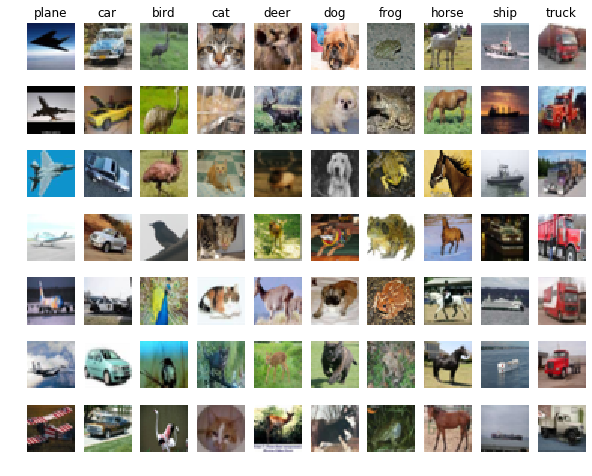

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [0]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


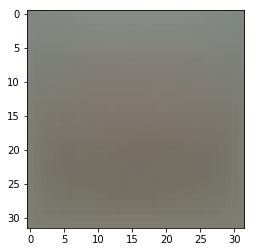

In [0]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print (mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [0]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [0]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [0]:
import time
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print ('loss: %f' % (loss, ))

loss: 9.497942


In [0]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -30.212512 analytic: -30.212512, relative error: 1.319922e-11
numerical: 29.043747 analytic: 29.043747, relative error: 1.357160e-11
numerical: 8.929030 analytic: 8.846924, relative error: 4.618919e-03
numerical: 9.185356 analytic: 9.185356, relative error: 2.289371e-11
numerical: -6.111137 analytic: -6.111137, relative error: 3.882143e-11
numerical: -4.008868 analytic: -4.008868, relative error: 1.081177e-10
numerical: -8.173288 analytic: -8.173288, relative error: 3.102810e-12
numerical: 1.098104 analytic: 1.098104, relative error: 2.886369e-10
numerical: 33.811508 analytic: 33.811508, relative error: 6.011079e-12
numerical: -11.408151 analytic: -11.408151, relative error: 1.653876e-11
numerical: -3.992289 analytic: -3.992133, relative error: 1.958407e-05
numerical: 3.321962 analytic: 3.321962, relative error: 1.148409e-11
numerical: 40.584829 analytic: 40.584829, relative error: 3.563583e-12
numerical: 23.436438 analytic: 23.436438, relative error: 7.205950e-12
numerical:

In [0]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print ('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.497942e+00 computed in 0.093240s
Vectorized loss: 9.497942e+00 computed in 0.013183s
difference: 0.000000


In [0]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('difference: %f' % difference)

Naive loss and gradient: computed in 0.090105s
Vectorized loss and gradient: computed in 0.010756s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [0]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print ('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1581.438771
iteration 100 / 1500: loss 213.114622
iteration 200 / 1500: loss 33.213768
iteration 300 / 1500: loss 9.598112
iteration 400 / 1500: loss 5.816175
iteration 500 / 1500: loss 5.890468
iteration 600 / 1500: loss 5.631621
iteration 700 / 1500: loss 5.668238
iteration 800 / 1500: loss 5.522551
iteration 900 / 1500: loss 5.966338
iteration 1000 / 1500: loss 5.776103
iteration 1100 / 1500: loss 5.489047
iteration 1200 / 1500: loss 5.445498
iteration 1300 / 1500: loss 5.612304
iteration 1400 / 1500: loss 5.733160
That took 8.779363s


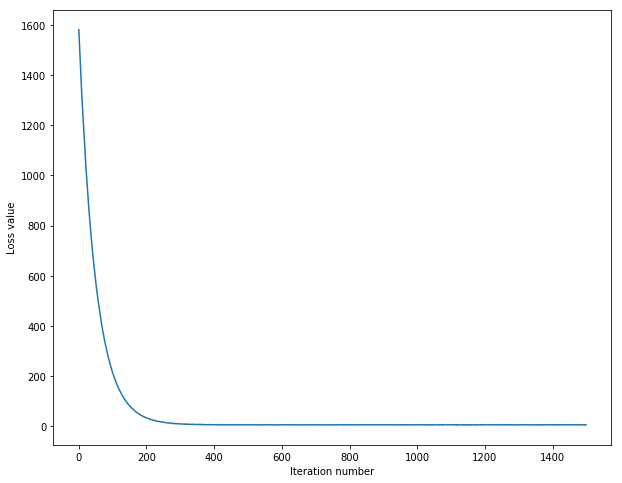

In [0]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [0]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.357959
validation accuracy: 0.369000


In [0]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
svm = LinearSVM()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hint = svm.train(X_train, y_train, learning_rate = lr, reg = reg,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train_pred == y_train)
        
        y_val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val_pred == y_val)
        results[(lr, reg)] = (acc_train, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 789.959971
iteration 100 / 1500: loss 710.703211
iteration 200 / 1500: loss 642.552219
iteration 300 / 1500: loss 579.094859
iteration 400 / 1500: loss 524.879011
iteration 500 / 1500: loss 474.076498
iteration 600 / 1500: loss 427.890141
iteration 700 / 1500: loss 388.896731
iteration 800 / 1500: loss 351.928892
iteration 900 / 1500: loss 318.774841
iteration 1000 / 1500: loss 288.849649
iteration 1100 / 1500: loss 261.313549
iteration 1200 / 1500: loss 236.005602
iteration 1300 / 1500: loss 214.286522
iteration 1400 / 1500: loss 193.512390
iteration 0 / 1500: loss 345.325375
iteration 100 / 1500: loss 283.374293
iteration 200 / 1500: loss 233.236965
iteration 300 / 1500: loss 191.655688
iteration 400 / 1500: loss 157.863478
iteration 500 / 1500: loss 129.682727
iteration 600 / 1500: loss 107.125602
iteration 700 / 1500: loss 89.268764
iteration 800 / 1500: loss 73.997612
iteration 900 / 1500: loss 61.196988
iteration 1000 / 1500: loss 51.049733
iteration 1100

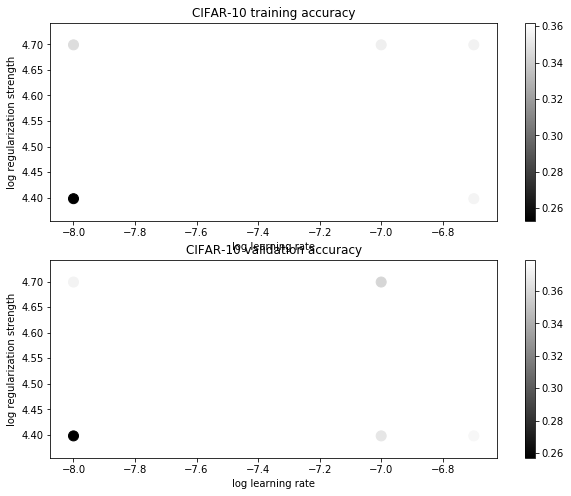

In [0]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [0]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373000


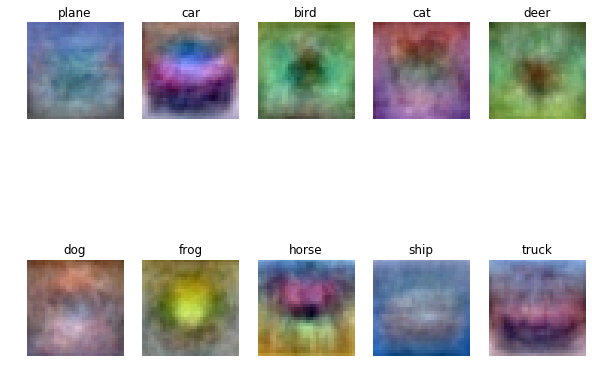

In [0]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])